In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import norm

import math
import os
import sys
sys.path.append("C:\\Users\\Sam Yu\\Documents\\GitHub\\LiquidCrystals")

from LiquidCrystalSystem import LCSystem

In [2]:
def get_config(r):
    
    if r == 0:
        particle_no_index = 3
        confinement = "Circle"
    else:
        particle_no_index = 4
        confinement = "Annulus"
    
    config = {"R": 25,
              "r": r,
              "b": 5,
              "a": 0.25,
              "confinement": confinement,
              "datasets_path": f"C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\datasets\\r={r}\\",
              "particle_no_index": particle_no_index}
    
    return config

In [3]:
run_config = get_config(r=0)

print(f"{run_config}\n")

globals().update(run_config)
    
# particle numbers
Ns = sorted([int(_path_.split("_")[particle_no_index]) for _path_ in os.listdir(datasets_path)])

print(f"Particle numbers: {Ns}")

{'R': 25, 'r': 0, 'b': 5, 'a': 0.25, 'confinement': 'Circle', 'datasets_path': 'C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\datasets\\r=0\\', 'particle_no_index': 3}

Particle numbers: [20, 50, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 210, 220, 230, 250]


particle number: 20 -> density: 0.0400
particle number: 50 -> density: 0.1000
particle number: 70 -> density: 0.1400
particle number: 75 -> density: 0.1500
particle number: 80 -> density: 0.1600
particle number: 85 -> density: 0.1700
particle number: 90 -> density: 0.1800
particle number: 95 -> density: 0.1900
particle number: 100 -> density: 0.2000
particle number: 105 -> density: 0.2100
particle number: 110 -> density: 0.2200
particle number: 115 -> density: 0.2300
particle number: 120 -> density: 0.2400
particle number: 125 -> density: 0.2500
particle number: 130 -> density: 0.2600
particle number: 135 -> density: 0.2700
particle number: 140 -> density: 0.2800
particle number: 145 -> density: 0.2900
particle number: 150 -> density: 0.3000
particle number: 155 -> density: 0.3100
particle number: 160 -> density: 0.3200
particle number: 165 -> density: 0.3300
particle number: 170 -> density: 0.3400
particle number: 175 -> density: 0.3500
particle number: 180 -> density: 0.3600
particle

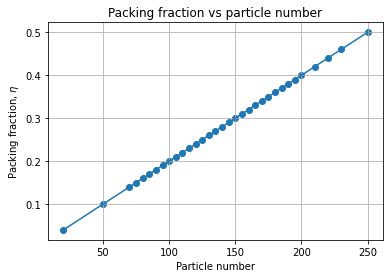

In [4]:
# Create the results directory for specified inner radius
base_results_path = f"C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\results\\2021_11_9\\"
results_path = os.path.join(base_results_path, f"r={r}")

if not os.path.exists(results_path):
    os.mkdir(results_path)
    
    
# Path for run at (number of features, number of samples)
num_of_features = 15
num_of_samples = 8

run_path = os.path.join(results_path, f"features_{num_of_features}_samples_{num_of_samples}")

if not os.path.exists(run_path):
    os.mkdir(run_path)
    

#### Plot the packing fractions with respect to particle number ####

# convert to densities
densities = [(N*a*b/(R**2-r**2)) for N in Ns]

for i, N in enumerate(Ns):
    print(f"particle number: {Ns[i]} -> density: {densities[i]:.4f}")

# Plot the packing fractions w.r.t particle number
with plt.ioff():
    fig, ax = plt.subplots()
    
ax.plot(Ns, densities)
ax.scatter(Ns, densities)
ax.set_xlabel("Particle number")
ax.set_ylabel(r"Packing fraction, $\eta$")
ax.set_title("Packing fraction vs particle number")
ax.grid()

fig.savefig(os.path.join(results_path, "packing_fraction_particles_no.png"))

plt.show()

plt.close(fig)

##### End plotting #####

In [5]:
systems = dict()

for _path_ in os.listdir(datasets_path):
    
    full_path = os.path.join(datasets_path, _path_, 'instanceRun')
    
    # Simulation summary notes exists
    if os.path.exists(os.path.join(full_path, f"MonteCarlo_{confinement}_SimNotes.txt")):
        
        lc = LCSystem(lc_data_path=full_path, confinement=confinement)
        num_of_particles = lc.sim_params['# of Ellipse']
        systems[num_of_particles] = lc
    
    # Simulation summary notes DNE
    else:
        
        lc = LCSystem(lc_data_path=full_path, confinement=confinement)
        lc.sim_params["R"] = R
        lc.sim_params["r"] = r
        lc.sim_params["Semi Major Axis"] = b
        lc.sim_params["Semi Minor Axis"] = a
        
        num_of_particles = lc.sim_params["# of Ellipse"]
        
        systems[num_of_particles] = lc

# remove outliers
#systems = {N:systems[N] for N in systems.keys() if N > 65 and N < 210}

for N in sorted(list(systems.keys())):
    print(f"Particle number: {N}, max step: {max(systems[N].snapshots.keys())}")

Particle number: 20.0, max step: 2000000.0
Particle number: 50.0, max step: 2000000.0
Particle number: 70.0, max step: 2000000.0
Particle number: 75, max step: 319999
Particle number: 80, max step: 279999
Particle number: 85, max step: 239999
Particle number: 90, max step: 219999
Particle number: 95, max step: 199999
Particle number: 100, max step: 179999
Particle number: 105, max step: 159999
Particle number: 110, max step: 139999
Particle number: 115, max step: 139999
Particle number: 120, max step: 119999
Particle number: 125, max step: 119999
Particle number: 130, max step: 99999
Particle number: 135, max step: 99999
Particle number: 140, max step: 79999
Particle number: 145, max step: 79999
Particle number: 150, max step: 79999
Particle number: 155, max step: 59999
Particle number: 160, max step: 59999
Particle number: 165, max step: 59999
Particle number: 170, max step: 59999
Particle number: 175, max step: 39999
Particle number: 180, max step: 39999
Particle number: 185, max ste

Conventional order parameter definition: $P^2_{max} = [<\frac{1}{N}\sum_{i=1}^{N}\cos(2\theta_i)>^2 + <\frac{1}{N}\sum_{i=1}^{N}\sin(2\theta_i)>^2]^{1/2}$

Particle number: 20.0, Order param: 0.03678430230725623
Particle number: 50.0, Order param: 0.023197058549491906
Particle number: 70.0, Order param: 0.07204103901304967
Particle number: 75, Order param: 0.13141239171819585
Particle number: 80, Order param: 0.3214156599468691
Particle number: 85, Order param: 0.4859711598112806
Particle number: 90, Order param: 0.49225174571640856
Particle number: 95, Order param: 0.5367125051968388
Particle number: 100, Order param: 0.6159356682508914
Particle number: 105, Order param: 0.5306770998834704
Particle number: 110, Order param: 0.749436970278935
Particle number: 115, Order param: 0.7455609977719126
Particle number: 120, Order param: 0.7742488508029095
Particle number: 125, Order param: 0.7425608114293205
Particle number: 130, Order param: 0.7555005684761967
Particle number: 135, Order param: 0.8413785369633197
Particle number: 140, Order param: 0.7948413759897527
Particle number: 145, Order param: 0.8481312907565153
Particle number: 150, Ord

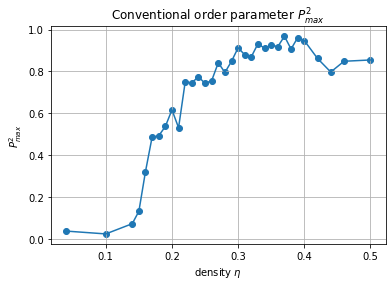

In [6]:
# Analysis using conventional order parameter

max_particle_num = max(systems.keys())
max_step = max(systems[max_particle_num].snapshots.keys())
min_step = min([step for step in systems[max_particle_num].snapshots.keys() if step > 0])

P2max = dict()

for particle_number in systems.keys():
    
    cosines = []
    sines = []
    system_state_at_mc_step = systems[particle_number].snapshots
        
    for mc_step in system_state_at_mc_step.keys():
            
        snapshot = system_state_at_mc_step[mc_step]

        mean_theta = np.mean([coord[-1] for coord in snapshot])
        thetas = np.array([coord[-1] for coord in snapshot]) - mean_theta

        cosine = np.mean([np.cos(2*theta) for theta in thetas])
        sine = np.mean([np.sin(2*theta) for theta in thetas])

        cosines.append(cosine)
        sines.append(sine)

    avg_cosine = np.mean(cosines)
    avg_sine = np.mean(sines)
    
    P2max[particle_number] = np.sqrt(avg_cosine**2 + avg_sine**2)
    
with plt.ioff():
    fig, ax = plt.subplots()
    
for key in sorted(list(P2max.keys())):
    print(f"Particle number: {key}, Order param: {P2max[key]}")
    
densities = sorted([N*a*b/(R**2-r**2) for N in P2max.keys()])
order_params = [P2max[N] for N in sorted(list(P2max.keys()))]

ax.plot(densities, order_params)
ax.scatter(densities, order_params)
ax.grid()
ax.set_xlabel(r"density $\eta$")
ax.set_ylabel(r"$P^2_{max}$")
ax.set_title(r"Conventional order parameter $P^2_{max}$")

fig.savefig(os.path.join(results_path, "p2max.png"))

plt.show()

plt.close()

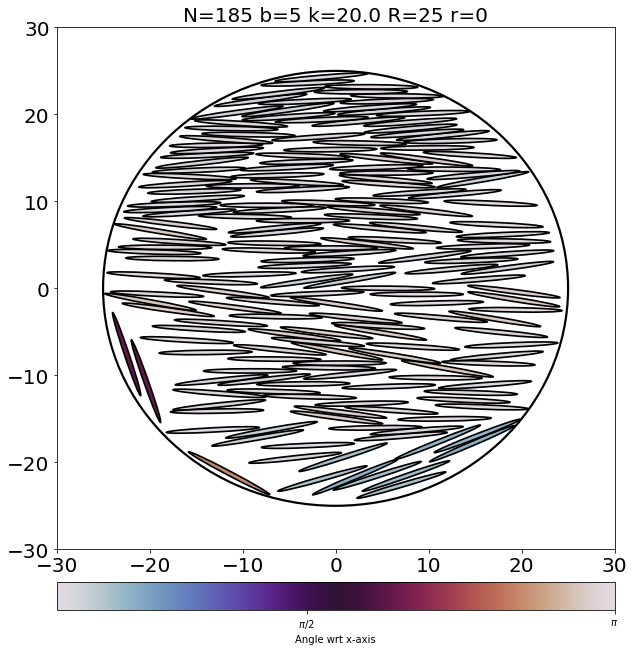

Step: 0, Cosine: 1.0, Sine: 0.0
Step: 19999, Cosine: 0.9531555018558946, Sine: 0.06521113340615904
Step: 39999, Cosine: 0.9515323654039348, Sine: 0.0200757483818884
Average cosine over all snapshots: 0.9682292890866098
Average sine over all snapshots: 0.028428960596015813
Order parameter: 0.9686465619851916


In [16]:
system = systems[185]

fig = system.plot_snapshot(39999, color_angles=True)

plt.show(fig)

plt.close()

cosines = []
sines = []

for step in sorted(list(system.snapshots.keys())):
    
    if step >= 0:
        
        snapshot = system.snapshots[step]
        
        mean_theta = np.mean([coord[-1] for coord in snapshot])
        thetas = np.array([coord[-1] for coord in snapshot]) - mean_theta

        cosine = np.mean([np.cos(2*coord[-1]) for coord in snapshot])
        sine = np.mean([np.sin(2*coord[-1]) for coord in snapshot])
        
        cosines.append(cosine)
        sines.append(sine)

        print(f"Step: {step}, Cosine: {cosine}, Sine: {sine}")

avg_cosine = np.mean(cosines)
avg_sine = np.mean(sines)

print(f"Average cosine over all snapshots: {avg_cosine}")
print(f"Average sine over all snapshots: {avg_sine}")

order_param = np.sqrt(avg_cosine**2 + avg_sine**2)
print(f"Order parameter: {order_param}")

In [8]:
def create_feature_vectors_from_snapshot(coordinates, num_features, num_samples,
                                         feature_func=lambda x, y: abs(np.cos(x - y))):
    
    assert (num_features < len(coordinates)), \
    f"Number of features {num_features} cannot be greater than number of particles {len(coordinates)}"
    
    #print(f"Input coordinates: {coordinates}")
    
    N = len(coordinates)
    
    # set the sampling rate for nearest neighbors
    if N % num_features == 0:
        nn_sampling_number = N / num_features - 1
    else:
        nn_sampling_number = math.floor(N / num_features)
    
    #print(f"Nearest neighbor sampling number: {nn_sampling_number}")
        
    # set a random seed for reproducibility
    rng = np.random.default_rng(666)
    probe_indices = rng.choice(N, size=num_samples, replace=False)
    
    # x, y positions for particle center of masses
    spatial = [c[:2] for c in coordinates]
    
    # angle of long axis with respect to x for particles
    angular = [(c[-1] % np.pi) for c in coordinates]
    
    mean_theta = np.mean(angular)
    angular = [theta - mean_theta for theta in angular]
    
    feature_vectors = []
    neighbor_coords = dict()
    
    for probe_index in probe_indices:
        
        # choose the probe molecule
        probe_coord = coordinates[probe_index]
        neighbor_coords[tuple(probe_coord)] = []
        
        norm2 = lambda x, y: (np.array(x) - np.array(y)) @ (np.array(x) - np.array(y))
        dist_to_P = lambda x: norm2(x[:2], probe_coord[:2])
        
        nn_sorted = sorted(coordinates, key=dist_to_P)
        #print(f"Nearest neighbor sort: {nn_sorted}")
        
        # feature vector
        fv = []
        
        # add feature based on nearest neighbor distance
        for i, c in enumerate(nn_sorted):
            
            # don't add the probe molecule
            if (i > 0) and (i % nn_sampling_number) == 0:
                
                feature = feature_func(c[-1], probe_coord[-1])
                fv.append(feature)
                neighbor_coords[tuple(probe_coord)].append(c)
            
            # Break the addition of features if total number of features is met
            if len(fv) == num_features:
                break
        
        feature_vectors.append(fv)
    
    return feature_vectors, neighbor_coords

In [9]:
# Create the data matrix from liquid crystal snapshots

data_matrix = []
samples = dict()

max_particle_num = max(systems.keys())
max_step = max(systems[max_particle_num].snapshots.keys())
min_step = min([step for step in systems[max_particle_num].snapshots.keys() if step > 0])

# iterate over densities
for particle_number in systems.keys():
    
    samples[particle_number] = []
    system_state_at_mc_step = systems[particle_number].snapshots
    
    # iterate over Monte Carlo steps
    for mc_step in system_state_at_mc_step.keys():
        
        if mc_step == max(system_state_at_mc_step.keys()):
            
            # Get snapshot of system at Monte Carlo step
            snapshot = system_state_at_mc_step[mc_step]
            
            # Create the feature vectors
            feature_vecs, _ = create_feature_vectors_from_snapshot(snapshot, num_features=num_of_features, 
                                                                   num_samples=num_of_samples)

            # Add to PCA data matrix
            data_matrix = data_matrix + feature_vecs
            
            for fv in feature_vecs:
                
                # subtract out the mean
                #fv = fv - np.mean(fv)
                
                samples[particle_number].append(fv)

                
data_matrix = np.stack(data_matrix, axis=0)

print(f"Shape of data matrix: {data_matrix.shape}")

Shape of data matrix: (264, 15)


First principal component: [-0.09409065 -0.10065901 -0.15476839 -0.18270028 -0.20062031 -0.2657854
 -0.30512065 -0.28090656 -0.32894966 -0.30348492 -0.3168349  -0.28877494
 -0.3685658  -0.25913915 -0.23174089]
Explained variance ratios: [0.4475028  0.08783082 0.06519569 0.06024262 0.0543202  0.04370232
 0.04038778 0.03724726 0.03145177 0.0304157  0.02604869 0.0237087
 0.02035303 0.0190623  0.01253039]


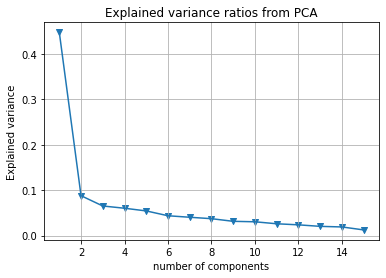

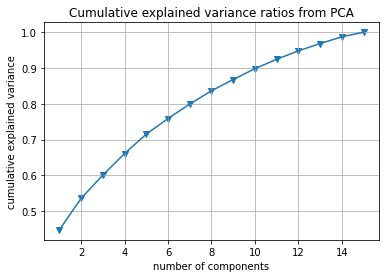

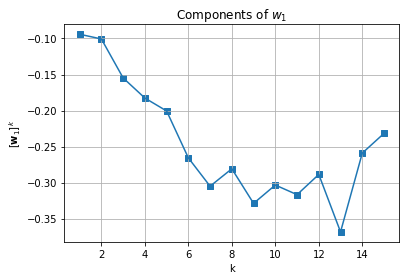

In [10]:
pca = PCA()
pca.fit(data_matrix)

print(f"First principal component: {pca.components_[0]}")
print(f"Explained variance ratios: {pca.explained_variance_ratio_}")

# explained variances
with plt.ioff():
    fig, ax = plt.subplots()
    
ax.plot(range(1, num_of_features+1), pca.explained_variance_ratio_)
ax.scatter(range(1, num_of_features+1), pca.explained_variance_ratio_, marker="v")
ax.grid()
ax.set_xlabel("number of components")
ax.set_ylabel("Explained variance")
ax.set_title("Explained variance ratios from PCA")

fig.savefig(os.path.join(run_path, "explained_variances.png"))

# Cumulative explained variance ratios
with plt.ioff():
    fig, ax = plt.subplots()
    
ax.plot(range(1, num_of_features+1), np.cumsum(pca.explained_variance_ratio_))
ax.scatter(range(1, num_of_features+1), np.cumsum(pca.explained_variance_ratio_), marker="v")
ax.grid()
ax.set_xlabel("number of components")
ax.set_ylabel("cumulative explained variance")
ax.set_title("Cumulative explained variance ratios from PCA")

fig.savefig(os.path.join(run_path, "cumulative_explained_variances.png"))

# weights of first principal component
with plt.ioff():
    c_fig, c_ax = plt.subplots()
    
c_ax.plot(range(1, num_of_features+1), pca.components_[0])
c_ax.scatter(range(1, num_of_features+1), pca.components_[0], marker="s")
c_ax.grid()
c_ax.set_xlabel("k")
c_ax.set_ylabel(r"$[\mathbf{w}_1]^k$")
c_ax.set_title(r"Components of $w_1$")

c_fig.savefig(os.path.join(run_path, "1st_pc_weights.png"))

plt.show()

plt.close(c_fig)

No. particles: 20.0, No. feature vectors: 8
No. particles: 50.0, No. feature vectors: 8
No. particles: 70.0, No. feature vectors: 8
No. particles: 75, No. feature vectors: 8
No. particles: 80, No. feature vectors: 8
No. particles: 85, No. feature vectors: 8
No. particles: 90, No. feature vectors: 8
No. particles: 95, No. feature vectors: 8
No. particles: 100, No. feature vectors: 8
No. particles: 105, No. feature vectors: 8
No. particles: 110, No. feature vectors: 8
No. particles: 115, No. feature vectors: 8
No. particles: 120, No. feature vectors: 8
No. particles: 125, No. feature vectors: 8
No. particles: 130, No. feature vectors: 8
No. particles: 135, No. feature vectors: 8
No. particles: 140, No. feature vectors: 8
No. particles: 145, No. feature vectors: 8
No. particles: 150, No. feature vectors: 8
No. particles: 155, No. feature vectors: 8
No. particles: 160, No. feature vectors: 8
No. particles: 165, No. feature vectors: 8
No. particles: 170, No. feature vectors: 8
No. particles

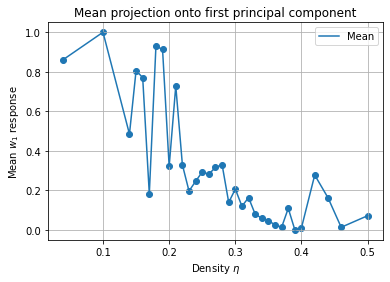

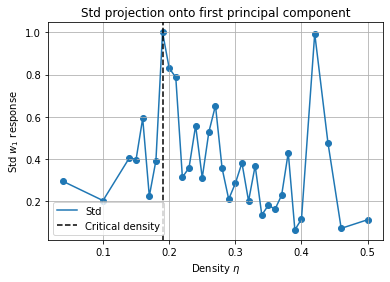

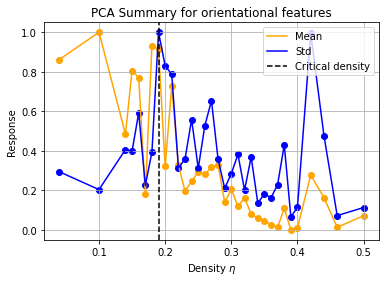

In [11]:
# Plot the response with respect to first component

w_1 = pca.components_[0]

means = []
stds = []

#scores_pca = pca.transform(data_matrix)[:, 0].reshape(len(samples.keys()), len(fvs))

# compute scores for each packing fraction value
for i, particle_number in enumerate(sorted(samples.keys())):
    
    fvs = samples[particle_number]
    
    print(f"No. particles: {particle_number}, No. feature vectors: {len(fvs)}")
    
    #scores = scores_pca[i]
    scores = np.array([w_1 @ vec for vec in fvs])
    #print(scores)
    
    avg = np.mean(scores)
    std = np.std(scores)
    
    means.append(avg)
    stds.append(std)

# convert to numpy
means = np.array(means)
stds = np.array(stds)

print(means)
print(stds)

# Normalize the values
norm_means = (means - min(means)) / max(means - min(means))
norm_stds = stds / max(stds)

densities = [N*a*b/(R**2-r**2) for N in sorted(samples.keys())]

critical_density = densities[np.argmax(norm_stds)]

with plt.ioff():
    mean_fig, mean_ax = plt.subplots()
    std_fig, std_ax = plt.subplots()
    all_fig, all_ax = plt.subplots()
    
### Plotting ###

# Mean projections
mean_ax.set_xlabel(r"Density $\eta$")
mean_ax.set_ylabel(r"Mean $w_1$ response")
mean_ax.grid()
mean_ax.plot(densities, norm_means, label="Mean")
mean_ax.scatter(densities, norm_means)
mean_ax.set_title("Mean projection onto first principal component")
mean_ax.legend()

# Std deviation of projections
std_ax.set_xlabel(r"Density $\eta$")
std_ax.set_ylabel(r"Std $w_{1}$ response")
std_ax.grid()
std_ax.plot(densities, norm_stds, label="Std")
std_ax.scatter(densities, norm_stds)
std_ax.set_title("Std projection onto first principal component")
std_ax.axvline(x=critical_density, linestyle="--", color="black", label="Critical density")
std_ax.legend()

# plotting them together
all_ax.set_xlabel(r"Density $\eta$")
all_ax.set_ylabel("Response")
all_ax.grid()
all_ax.plot(densities, norm_means, color="orange", label="Mean")
all_ax.scatter(densities, norm_means, color="orange")
all_ax.plot(densities, norm_stds, color="blue", label="Std")
all_ax.scatter(densities, norm_stds, color="blue")
all_ax.set_title("PCA Summary for orientational features")
all_ax.axvline(x=critical_density, linestyle="--", color="black", label="Critical density")
all_ax.legend()
###

print("\n")
print(fr"Critical density detected at eta = {critical_density:.4f} by PCA")

mean_fig.savefig(os.path.join(run_path, "means.png"))
std_fig.savefig(os.path.join(run_path, "stds.png"))
all_fig.savefig(os.path.join(run_path,"all.png"))

plt.show()

plt.close(mean_fig)
plt.close(std_fig)
plt.close(all_fig)

# Write critical density to text file
phase_transition_file = os.path.join(results_path, "phase_transition_IN.txt")

with open(phase_transition_file, "w") as out_file:
    out_file.write(f"critical density: {critical_density}")

In [12]:
# Visualize how the feature function chooses
# also plot the snapshots

if not os.path.exists(os.path.join(run_path, "method")):
    os.mkdir(os.path.join(run_path, "method"))

for N in systems.keys():
    
    lc_system = systems[N]
    
    # maximally equilibrated step
    step_number = max(lc_system.snapshots.keys())
    
    # input coordinates
    input_coords = lc_system.snapshots[step_number]
    
    # feature vectors and coordinates of feature particles
    _, ncs = create_feature_vectors_from_snapshot(input_coords, num_of_features, num_samples=3)
    
    # plot neighbors
    for i, probe in enumerate(list(ncs.keys())):
        particles_to_plot = [probe] + ncs[probe]
        fig = lc_system.plot_snapshot(step_number, extra_particles=particles_to_plot)
        
        fig.savefig(os.path.join(run_path, "method", f"N_{N}_figure_{i}.png"))
        plt.close(fig)

In [13]:
# plot all the snapshots

if not os.path.exists(os.path.join(results_path, "plots")):
    os.mkdir(os.path.join(results_path, "plots"))
    
for N in systems.keys():

    lc_system = systems[N]

    # snapshots
    for step in lc_system.snapshots.keys():

        fig = lc_system.plot_snapshot(step, color_angles=True)
        fig.savefig(os.path.join(results_path, "plots", f"N_{N}_step_{step}.png"))
        plt.close(fig)

C:\Users\Sam Yu\Documents\GitHub\LiquidCrystals\LiquidCrystalSystem.py:95: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(e, ticks=[0, 0.5, 1], label="Angle wrt x-axis",


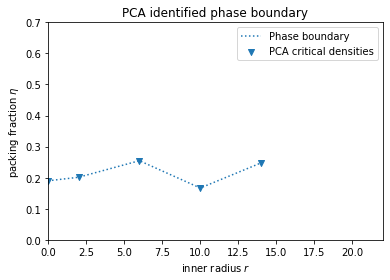

In [14]:
# phase transition

rs = [0, 2, 6, 10, 14]

densities = []
for rp in rs:
    txt_path = os.path.join(base_results_path, f"r={rp}", "phase_transition_IN.txt")
    with open(txt_path, "r") as in_file:
        density = float(in_file.readline().strip().split(" ")[-1])
        densities.append(density)

with plt.ioff():
    fig, ax = plt.subplots()
    
ax.plot(rs, densities, linestyle="dotted", label="Phase boundary")
ax.scatter(rs, densities, marker="v", label="PCA critical densities")
ax.set_xlabel(r"inner radius $r$")
ax.set_ylabel(r"packing fraction $\eta$")
ax.set_xlim(0, 22)
ax.set_ylim(0, 0.7)
ax.set_title("PCA identified phase boundary")
ax.legend()

plt.show(fig)
plt.close(fig)

In [15]:
print(pca.n_features_)
print(pca.n_samples_)

15
264
